# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from ObjectDetection.helper.object_detection_helper import *
from ObjectDetection.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from ObjectDetection.models.RetinaNet import RetinaNet
from ObjectDetection.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

import warnings
warnings.filterwarnings('ignore')

# 2. ข้อมูล

In [3]:
path = untar_data(URLs.COCO_SAMPLE)
images, lbl_bbox = get_annotations(path/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [4]:
path

PosixPath('/home/jupyter/.fastai/data/coco_sample')

In [5]:
size = 256

# 3. เตรียมข้อมูล



In [6]:
data = (ObjectItemList.from_folder(path)
        .split_by_rand_pct()
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=size)
        .databunch(bs=32, collate_fn=bb_pad_collate)).normalize(imagenet_stats)

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch

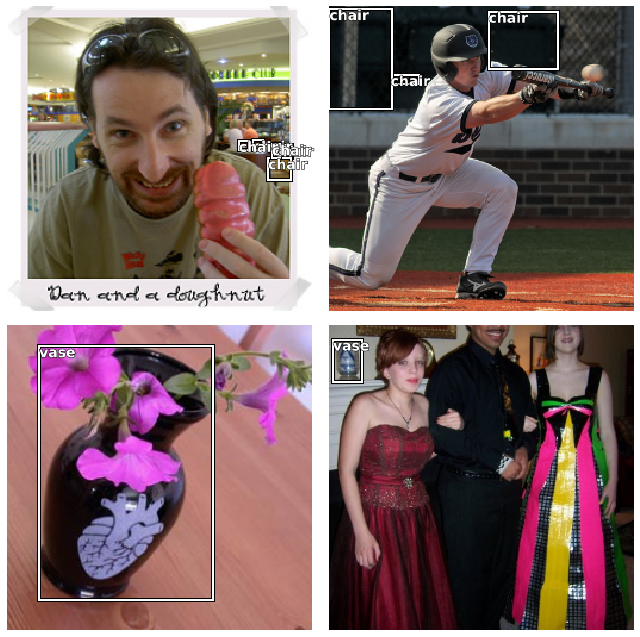

In [7]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(9,9))

In [8]:
data.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

In [9]:
[1,2**(1/3), 2**(2/3)]

[1, 1.2599210498948732, 1.5874010519681994]

In [10]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [11]:
len(anchors)

24480

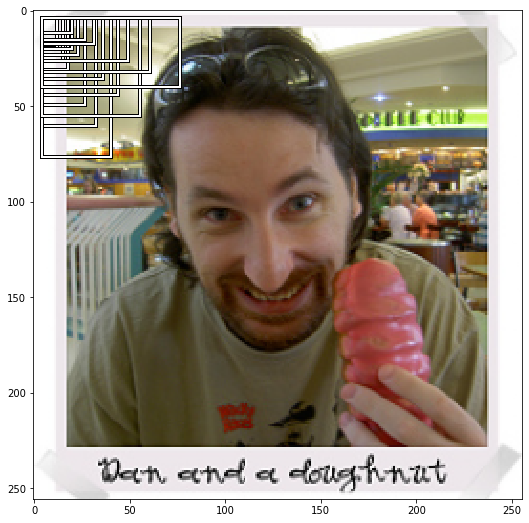

In [12]:
fig,ax = plt.subplots(figsize=(9,9))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [13]:
# all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [14]:
data.train_ds.c

7

# 4. สร้างโมเดล

In [15]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet34, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

In [16]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learner = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [17]:
learner.split([model.encoder[6], model.c5top5]);

# 5. เริ่มต้นเทรนโมเดล

In [18]:
learner.freeze_to(-2)

In [ ]:
learner.fit_one_cycle(3, max_lr=3e-3)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-book,AP-chair,AP-couch,AP-remote,AP-tv,AP-vase,time


In [ ]:
learner.save("13a-object-detection-1")

In [ ]:
learner.load("13a-object-detection-1");

# 6. เทรนต่อ

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(10, mar_lr=slice(3e-6, 3e-4))

In [ ]:
learner.save("13a-object-detection-2")

In [ ]:
learner.load("13a-object-detection-2");

## สำเร็จแล้ว ##

เพียงแค่เวลา x นาที เราเทรน Model เรียบร้อย


# 7. ดูผลลัพธ์

In [ ]:
show_results_side_by_side(learner, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=5)

# 8. สรุป


1. เราสามารถสร้างโมเดล

# Credit

* https://github.com/ChristianMarzahl/ObjectDetection
* https://arxiv.org/abs/1708.02002
* https://github.com/fastai/fastai_dev/blob/master/dev_nb/102a_coco.ipynb
* https://github.com/rafaelpadilla/Object-Detection-Metrics